The goal of this notebook is to apply Principal Component Analysis in order to select important features from our nba dataset

Reading material:

- [pca clearly explained and when to use it](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e/?source=friends_link&sk=65bf5440e444c24aff192fedf9f8b64f)
- [step by step manually implementing and explaining](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html)
- [docs page for the pca python package](https://erdogant.github.io/pca/pages/html/index.html)
    - [demo of feature importance](https://erdogant.github.io/pca/pages/html/Examples.html#demonstration-of-feature-importance)

# 1. Importing Packages and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

In [3]:
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')


df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,7.0,11.0,0.636,16.0,19.0,0.842,8.0,30.0,38.0,4.0,7.0,13.0,20.0,81.0,7.0,99.6,105.2,91.2,94.9,8.4,10.3,0.483,1.08,13.5,0.317,0.696,0.517,15.978,16.9,0.478,0.530,1.0,0.201,81.26,77.5,64.58,77.0,0.542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,8.0,28.0,0.286,16.0,26.0,0.615,13.0,30.0,43.0,3.0,2.0,11.0,18.0,86.0,-9.0,100.7,107.5,119.7,117.3,-19.1,-9.8,0.484,1.25,13.2,0.383,0.696,0.538,14.045,15.0,0.467,0.497,1.0,0.197,82.40,80.5,67.08,80.0,0.408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,2.0,9.0,0.222,19.0,23.0,0.826,16.0,26.0,42.0,7.0,11.0,11.0,20.0,95.0,-1.0,105.4,108.0,107.6,109.1,-2.2,-1.1,0.459,1.42,13.8,0.438,0.571,0.505,13.316,13.6,0.452,0.505,1.0,0.198,81.22,79.7,66.42,88.0,0.557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,2.0,9.0,0.222,18.0,23.0,0.783,13.0,34.0,47.0,13.0,6.0,3.0,22.0,102.0,31.0,111.9,117.2,82.0,80.7,29.9,36.6,0.561,5.75,18.1,0.327,0.714,0.515,4.390,4.6,0.467,0.509,1.0,0.196,88.84,87.5,72.92,87.0,0.736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,3.0,14.0,0.214,13.0,17.0,0.765,17.0,27.0,44.0,12.0,10.0,11.0,18.0,96.0,17.0,109.7,115.7,94.3,95.2,15.5,20.5,0.550,1.83,17.4,0.429,0.683,0.544,13.717,14.5,0.488,0.519,1.0,0.193,85.64,83.0,69.17,83.0,0.640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


## 1.2 Filtering down df 

So we discovered that many of the columns (like `touches`,`passes`,`assists`, etc) have a 0 for games prior the `2013-14` season. It is likely that those stats were not being tracked then but have elected to do the following (intentionally overwriting `df`):
- keep only regular and playoff games
- keep games from `2013-14` season and onward

Instead of utilitzing the `is_playoff_game` and `is_regular_game` (because of prior inconsistencies) we will be creating a termporary string version of `game_id` to use in the filtering

In [4]:
shape_before = df.shape

df['game_id_2'] = df['game_id'].astype('string')
df = df[(df.game_id_2.str.startswith('2', na=False)) | (df.game_id_2.str.startswith('4', na=False))]

print(f'Shape before: {shape_before}\n Shape after concat regular and playoff: {df.shape}')

Shape before: (55314, 72)
 Shape after concat regular and playoff: (51420, 73)


The following function should add an indicator column for simple subset of games past `2013-14` season

In [5]:
def has_acceptable_season(row):
    acceptable_seasons = [
        '2013-14',
        '2014-15',
        '2015-16',
        '2016-17',
        '2017-18',
        '2018-19',
        '2019-20',
        '2020-21',
        '2021-22',
        '2022-23',
        '2023-24'
    ]
    if row['season'] in acceptable_seasons:
        return 1
    else:
        return 0

Using the function and subsetting for when `acceptable_season` == 1 results in the following

In [6]:
shape_before = df.shape

df['acceptable_season'] = df.apply(has_acceptable_season, axis=1)
df = df.loc[df['acceptable_season'] == 1]

print(f'Shape before filtering for acceptable_season: {shape_before}\n Shape after filtering for acceptable_season: {df.shape}')

Shape before filtering for acceptable_season: (51420, 73)
 Shape after filtering for acceptable_season: (28258, 74)


Dropping the `acceptable_season` column since it was only created and needed for this section

In [7]:
df = df.drop(columns=['acceptable_season', 'game_id_2'], axis=1)

Experimental change to exclude values where 0 in specific columns doesnt make sense

In [8]:
df = df.loc[df.distance != 0] 
# Future note: You can expand on this by using df.loc[(df.distance != 0) | (df.opponent_points != 0)] 

# 2. Preprocess data

Before running PCA we need to:
1. Drop obvious non numeric columns
2. Decide which and drop dummy variables
3. Handle missing values
4. Standardize the numeric features (since PCA works best with standardized data)  

**Step 1. Drop the obvious/non numeric columns**
- `game_id`
- `season`
- `team_id`
- `team_name`
- `tri_code`
- `team_slug`
- `minutes`: right now is a string like object





In [9]:
drop_cols1 = [
    'game_id',
    'season',
    'team_id',
    'team_name',
    'tri_code',
    'team_slug',
    'minutes'
]

df = df.drop(columns=drop_cols1, axis=1)

**Step 2. Decide and drop dummy variables**

Going to check the variance of each dummy variable since if the variance is close to 0 it wont really contribute much to PCA and can be dropped

In [10]:
df[['is_home_team', 'won_game', 'is_playoff_game', 'is_regular_game']].var()

is_home_team       0.250009
won_game           0.250009
is_playoff_game    0.061098
is_regular_game    0.061098
dtype: float64

Since .25 is the maximum variance possible for binary dummy variable we'll keep `is_home_team` and `won_game` and drop `is_playoff_game` and `is_regular_game`

In [11]:
drop_cols3 = [
    'is_playoff_game',
    'is_regular_game'
]

df = df.drop(columns=drop_cols3, axis=1)

At this point `df` should only have numeric colums and will be renamed to `df_num` 

In [12]:
df_num = df.select_dtypes(include=np.number)
assert list(df.columns) == list(df_num.columns)

In [13]:
df_num = df
df_num.head()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game
12495,37.0,78.0,0.474,12.0,26.0,0.462,18.0,23.0,0.783,6.0,34.0,40.0,5.0,4.0,8.0,21.0,104.0,17.0,115.4,116.9,92.7,97.8,22.7,19.1,0.676,3.13,20.6,0.178,0.750,0.473,8.877,9.0,0.551,0.590,1.0,0.200,92.00,89.0,74.17,89.0,0.622,17.60,32.0,61.0,90.0,467.0,4.0,1.0,357.0,25.0,18.0,38.0,0.474,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1
12496,32.0,71.0,0.451,9.0,22.0,0.409,13.0,20.0,0.650,6.0,21.0,27.0,7.0,1.0,13.0,25.0,86.0,-21.0,99.1,101.2,128.9,127.4,-29.8,-26.2,0.406,1.00,12.3,0.000,0.000,0.000,14.977,15.3,0.514,0.539,1.0,0.203,84.90,84.5,70.42,85.0,0.297,16.83,21.0,38.0,57.0,377.0,0.0,1.0,274.0,13.0,14.0,30.0,0.467,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0
12497,32.0,62.0,0.516,10.0,21.0,0.476,18.0,24.0,0.750,5.0,21.0,26.0,8.0,1.0,20.0,26.0,92.0,-19.0,105.1,108.2,128.9,129.1,-23.9,-20.8,0.531,0.85,15.5,0.229,0.733,0.462,22.841,23.5,0.597,0.634,1.0,0.199,86.82,85.5,71.25,85.0,0.365,16.36,21.0,40.0,57.0,361.0,2.0,0.0,256.0,17.0,16.0,31.0,0.516,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0
12498,36.0,82.0,0.439,12.0,26.0,0.462,12.0,20.0,0.600,11.0,26.0,37.0,7.0,1.0,11.0,20.0,96.0,-2.0,105.7,109.1,108.6,110.1,-2.9,-1.0,0.722,2.36,20.3,0.260,0.000,0.000,12.115,12.5,0.512,0.529,1.0,0.196,90.52,88.5,73.75,88.0,0.478,16.80,25.0,37.0,60.0,436.0,6.0,1.0,325.0,26.0,17.0,40.0,0.425,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0
12499,40.0,68.0,0.588,13.0,25.0,0.520,17.0,22.0,0.773,5.0,34.0,39.0,8.0,4.0,22.0,14.0,110.0,15.0,115.0,115.8,101.2,100.0,13.7,15.8,0.750,1.30,23.0,0.258,0.814,0.581,24.038,24.2,0.684,0.708,1.0,0.199,94.76,95.0,79.17,95.0,0.626,17.48,17.0,57.0,72.0,441.0,2.0,3.0,333.0,30.0,23.0,32.0,0.719,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1


**Step 3. Handle missing values**

A prior notebook somehwere has the code for why dropping instead of imputing is fine

In [14]:
df.isna().sum().divide(len(df)).sort_values(ascending=False)

turnover_ratio                0.000142
estimated_defensive_rating    0.000142
net_rating                    0.000142
assist_percentage             0.000142
assist_to_turnover            0.000142
                                ...   
blocks                        0.000000
turnovers                     0.000000
fouls_personal                0.000000
points                        0.000000
won_game                      0.000000
Length: 63, dtype: float64

In [15]:
shape_before = df_num.shape
df_num = df_num.dropna()

print(f'Shape before dropping nas: {shape_before}\n Shape after dropping nas: {df_num.shape}')

Shape before dropping nas: (28148, 63)
 Shape after dropping nas: (28142, 63)


**Step 4. Standardize numeric features**

We will be using `StandardScaler` from scikit learn for this ([docs link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler))



There is no conclusive opinion on whether or not to scale the binary dummy variables.

In [16]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# convert back to dataframe
df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)

# 3. Running PCA

## via scikit learn

Looked over the sklearn docs page once more and thought to try using svd with variance based `n_components` parameter (0 < value < 1)

https://scikit-learn.org/1.6/modules/generated/sklearn.decomposition.PCA.html 

Initialize, fit, and train PCA() class. Looking for features that cumulativate account for at least 90% of the variance in the dataset 

In [17]:
model = PCA(
    n_components=0.9,   # Change this value if looking to reduce to specific number of components or different cumulative variance explained 
    svd_solver='full'
).fit(df_scaled)

result = model.transform(df_scaled)

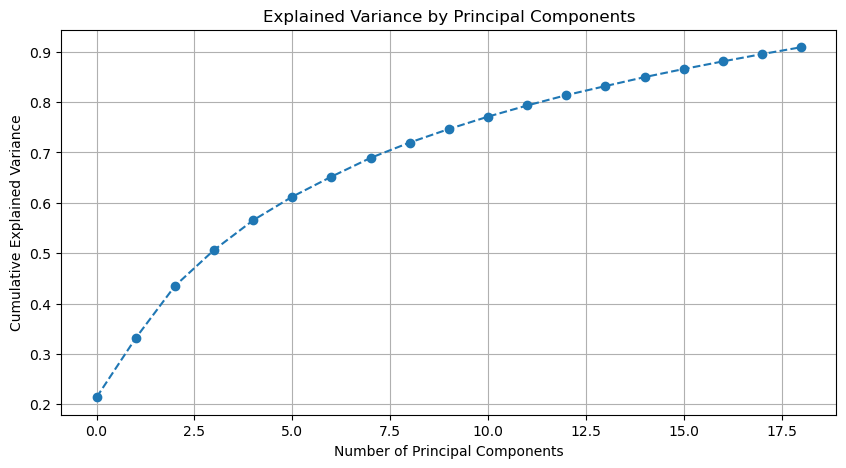

1

In [18]:
explained_variance = model.explained_variance_ratio_

# plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# find number of components to explain 95% variance
num_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1

# number of components needed to retain 95% variance
num_components

## via pca library

In [19]:
from pca import pca

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [63] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [19] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [63] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[19]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 19 Principal Components explain [92.11%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

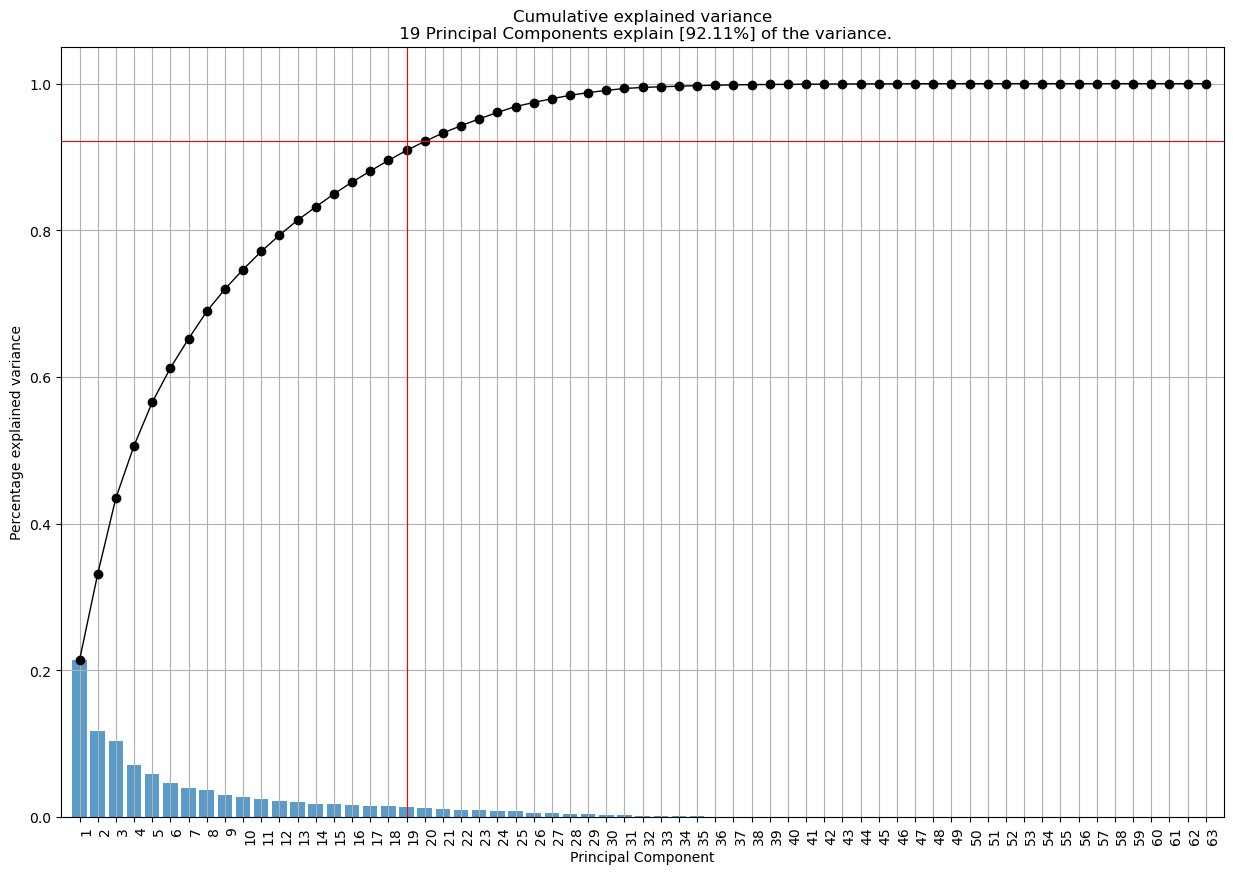

In [20]:
model_2 = pca(n_components=0.9)
result_2 = model_2.fit_transform(df_scaled)

model_2.plot()

In [21]:
result_2['topfeat'].loc[result_2['topfeat']['type'] == 'best']

,PC,feature,loading,type
0,PC1,effective_field_goal_percentage,0.248772,best
1,PC2,opponent_points,0.341901,best
2,PC3,possessions,0.310328,best
3,PC4,estimated_team_turnover_percentage,0.410043,best
4,PC5,contested_field_goals_made,0.333379,best
5,PC6,free_throws_made,0.273674,best
6,PC7,offensive_rebound_percentage,0.391543,best
7,PC8,free_throws_made,0.391204,best
8,PC9,rebound_percentage,0.447156,best
9,PC10,steals,0.567001,best


The resuls from both approaches seem to agree with each other which satisfies me.

In [64]:
print(model.components_)

[[ 0.22886786  0.03180217  0.2331329  ...  0.02106753  0.03553052
   0.16778465]
 [ 0.07480827  0.10608407  0.00718648 ...  0.34190083 -0.04879351
  -0.19861747]
 [ 0.0629218   0.25290915 -0.11062661 ...  0.05510569  0.01141777
   0.02562781]
 ...
 [ 0.07483528 -0.00562991  0.08749491 ...  0.01471597 -0.40981344
  -0.010094  ]
 [ 0.00155801 -0.04773939  0.03655754 ... -0.0245791   0.46672562
  -0.01134076]
 [-0.08861466 -0.01508202 -0.08672288 ... -0.02176223 -0.00755233
  -0.00972093]]


In [52]:
result_2['loadings']

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game
PC1,0.228868,0.031802,0.233133,0.168432,0.079791,0.166272,0.010226,-0.003911,0.036740,-0.057353,0.059048,0.015518,0.019764,0.031749,-0.038881,-0.000252,0.241644,0.202304,0.245340,0.242253,-0.014174,-0.010283,0.202929,0.201940,0.083977,0.131219,0.199842,0.000438,0.034995,0.047089,-0.050368,-0.053649,0.248772,0.244526,0.000000e+00,-0.031477,0.061237,0.065912,0.065911,0.065071,0.200574,0.052518,-0.110372,0.019989,-0.053998,0.007698,0.094880,0.027222,0.006767,0.202790,0.058341,-0.060290,0.142986,0.198011,0.086016,0.188718,0.233121,0.025201,0.037665,-0.013647,0.021068,0.035531,0.167785
PC2,0.074808,0.106084,0.007186,0.096091,0.134502,-0.002518,0.006807,0.003941,0.004513,-0.030666,-0.176188,-0.162784,-0.018301,-0.084987,-0.017574,0.038233,0.093299,-0.228008,0.030072,0.034766,0.321517,0.319272,-0.227894,-0.227507,0.022831,0.053345,0.033273,-0.012795,0.015952,0.012396,-0.057100,-0.055356,0.031683,0.027276,-0.000000e+00,0.004751,0.134253,0.140302,0.140302,0.130435,-0.229222,0.132654,-0.076568,-0.217619,-0.201258,0.007997,0.008512,0.038180,-0.009805,0.061022,0.002110,-0.020050,0.022255,0.079667,0.119852,-0.004530,0.007171,0.193638,0.107843,0.172349,0.341901,-0.048794,-0.198617
PC3,0.062922,0.252909,-0.110627,0.027639,0.112555,-0.083737,0.071888,0.081602,-0.010451,0.165213,0.216325,0.273498,0.072423,0.084586,0.106339,0.081377,0.091846,0.033697,-0.071961,-0.066595,-0.105948,-0.106979,0.026577,0.032291,0.002128,-0.055229,-0.063078,0.109077,0.081348,0.111098,0.035811,0.038218,-0.100899,-0.096910,0.000000e+00,0.014310,0.288849,0.281151,0.281151,0.310328,0.023991,0.222950,0.146714,0.168867,0.205662,0.148303,0.003259,0.050230,0.081442,0.039012,0.060386,0.126200,-0.057430,0.022038,0.133663,-0.099389,-0.110671,0.078788,0.123104,-0.050558,0.055106,0.011418,0.025628
PC4,-0.073920,-0.279997,0.118659,-0.009355,-0.068275,0.064721,0.079359,0.081562,0.007432,-0.176169,0.025944,-0.080325,0.042480,0.018667,0.408824,0.081373,-0.026703,-0.038555,-0.072665,-0.084545,-0.037058,-0.037777,-0.027858,-0.037387,0.025789,-0.321788,-0.017165,-0.090865,-0.003379,-0.020657,0.410043,0.403995,0.116534,0.139086,0.000000e+00,-0.018267,0.119293,0.129531,0.129530,0.096130,-0.008366,-0.006629,-0.145834,0.028528,-0.072610,0.015430,-0.007476,0.039750,0.021694,-0.025053,-0.048187,-0.134784,0.081026,-0.040157,-0.145543,0.086711,0.118692,0.062175,0.070936,-0.001358,0.015334,-0.013169,-0.020006
PC5,0.096232,-0.012306,0.117290,-0.209934,-0.244865,-0.049711,0.267058,0.267970,0.041570,0.109897,-0.059450,0.014480,-0.005930,-0.009802,-0.035774,0.087236,0.133106,0.026925,0.132401,0.135624,0.097279,0.101870,0.027458,0.027001,-0.281908,-0.052457,-0.179202,0.097544,-0.068246,-0.021223,-0.050747,-0.050640,0.023595,0.075349,0.000000e+00,0.027381,0.031030

# 4. Determining Important Features

## Via median/mean loading threshold

From what I understood from Dr. Baidoo's office hours, this approach will first calculate the median loading value across *all* the principal components (= num pc * num features). This value will be used as a comparison threshold while iterating through each loading value across all the principal components. An absolute value of loading greater than the threshold indicates an important feature. Since each principal component has a loading value for each feature, it is possible to have the same feature flagged multiple times; this is not a issue.

Note that I also want to try implementing a mean loading value threshold to see how it affects the important features identified.

19 principal components x 63 features

In [34]:
model.components_.shape

(19, 63)

First we'll flatten `model.components_` down to a 1D array and calculate the median and mean thresholds

In [35]:
flattened_loadings = model.components_.flatten()
median_loading = np.median(flattened_loadings)
mean_loading = np.mean(flattened_loadings)

print(f'median threshold value: {median_loading}')
print(f'mean threshold value: {mean_loading}')

median threshold value: 0.00676685214774688
mean threshold value: 0.014130165190764687


Hmm I see a potential issue. With such a low threshold its possible that many if not all feature loadings may being counted as important

This function identifies the important features with the selection criteria discussed in Dr. Baidoo's office hours.

In [66]:
def select_important_features(components, col_names, method='median'):
    # Flatten loadings to get one-dimensional array
    flattened_loadings = components.flatten()
    
    if 'median' in method: 
        # Compute median of all loadings
        threshold_loading_value = np.median(flattened_loadings)
    elif 'mean' in method:
        # Compute mean of all loadings
        threshold_loading_value = np.mean(flattened_loadings)

    # Identify "important" features
    important_features = []
    for i, col_name in enumerate(col_names):
        # Check if any loading for this feature is above the median
        if np.any(abs(components[:, i]) > threshold_loading_value):
            important_features.append(col_name)
    
    # Return the list of important feature names
    return list(set(important_features))

Using the function gives us the following:

In [67]:
flattened_loadings = model.components_.flatten()

important_features_median = select_important_features(model.components_, list(df_num.columns), method='median')
print(f'Number of identified features by median based threshold: {len(important_features_median)}')

important_features_mean = select_important_features(model.components_, list(df_num.columns), method='mean')
print(f'Number of identified features by mean based threshold: {len(important_features_mean)}')

Number of identified features by median based threshold: 62
Number of identified features by mean based threshold: 62


That is what I was worried about

### Attempt 2 

This time around I will try having calculating the threshold according to the loading values within a single principal component (instead of accross all of them). 

In [68]:
def select_important_features_v2(components, col_names, method='median'):
    assert len(components[0]) == len(col_names)
    
    if 'median' in method: 
        func = np.median
    elif 'mean' in method:
        func = np.mean

    # Identify "important" features
    threshold_loading_value = 0
    important_features = []

    for idx in range(len(components)):
        component = components[idx]
        threshold_loading_value = func(component)
        for i, col_name in enumerate(col_names):
            if abs(component[i]) > threshold_loading_value:
                important_features.append(col_name)
                
    # Return the list of important feature names
    return list(set(important_features))

In [ ]:
# scratch work space

func = np.mean
col_names = list(df.columns)
components = model.components_
important_features = []
for idx in range(len(components)):
    component = components[idx]
    threshold_loading_value = func(component)
    print(f'threshold value for components[{idx}]: {threshold_loading_value}')
    for i, col_name in enumerate(col_names):
        if component[i] > threshold_loading_value:
            important_features.append(col_name)

In [69]:
flattened_loadings = model.components_.flatten()

important_features_median = select_important_features_v2(model.components_, list(df_num.columns), method='median')
print(f'Number of identified features by median based threshold: {len(important_features_median)}')

important_features_mean = select_important_features_v2(model.components_, list(df_num.columns), method='mean')
print(f'Number of identified features by mean based threshold: {len(important_features_mean)}')


Number of identified features by median based threshold: 63
Number of identified features by mean based threshold: 63


## Via top n highest loading values from each component

Since using a mean/median threshold loading value is not working, the following function goes through each of the principal components and identifies the indices correlating with the top n loading values.

In [29]:
from itertools import chain
# need itertools to flatten out the nested list in each row of top_n_features columns

def identify_important_features(model, col_names, n)->pd.DataFrame:
    """ 
    Returns a dataframe to identify the top n features from each principal component 
    """
    # number of components
    n_pcs = model.components_.shape[0]

    # find the top-n most important features for EACH component
    top_n_features = []
    for i in range(n_pcs):
        loadings = np.abs(model.components_[i])  # absolute value of loadings
        # 1) argpartition to get indices of the top n loadings (unsorted)
        topn_idx_unsorted = np.argpartition(loadings, -n)[-n:]
        # 2) sort those topn indices by actual loading value (descending)
        topn_idx_sorted = topn_idx_unsorted[np.argsort(-loadings[topn_idx_unsorted])]
        # 3) map indices to column names
        top_n = [col_names[idx] for idx in topn_idx_sorted]
        top_n_features.append(top_n)

    # build a dictionary: key=PC name, value=list of top-n feature names
    tmp = {"PC{}".format(i): top_n_features[i] for i in range(n_pcs)}

    # use the tmp dictionary to fill up a dataframe
    important_features_df = pd.DataFrame(tmp.items(), columns=['principal_component', 'top_n_features'])
    return important_features_df

So here are the identified important features when n=1

In [70]:
# goofy list set list usage to avoid seeing duplicate feature names
important_features = list(
    set(
        list(
            chain.from_iterable(
                identify_important_features(model=model,col_names=list(df_num.columns),n=1)['top_n_features'].to_list())
            )
        )
    )
print(len(important_features))
important_features



16


['possessions',
 'contested_field_goals_made',
 'is_home_team',
 'estimated_team_turnover_percentage',
 'defensive_rebound_percentage',
 'defended_at_rim_field_goals_attempted',
 'offensive_rebound_percentage',
 'free_throws_made',
 'estimated_usage_percentage',
 'steals',
 'free_throws_percentage',
 'rebound_percentage',
 'fouls_personal',
 'effective_field_goal_percentage',
 'assist_percentage',
 'opponent_points']

These are the identified important features when n=2

In [71]:

important_features = list(
    set(
        list(
            chain.from_iterable(
                identify_important_features(model=model,col_names=list(df_num.columns),n=2)['top_n_features'].to_list())
            )
        )
    )
print(len(important_features))
important_features



29


['defended_at_rim_field_goals_made',
 'possessions',
 'contested_field_goals_made',
 'free_throws_percentage',
 'fouls_personal',
 'free_throws_attempted',
 'rebound_chances_defensive',
 'rebounds_offensive',
 'contested_field_goals_attempted',
 'is_home_team',
 'estimated_team_turnover_percentage',
 'defended_at_rim_field_goals_attempted',
 'defended_at_rim_field_goal_percentage',
 'rebound_percentage',
 'free_throws_made',
 'three_pointers_made',
 'estimated_offensive_rating',
 'defensive_rebound_percentage',
 'assist_percentage',
 'turnovers',
 'opponent_points',
 'passes',
 'estimated_defensive_rating',
 'estimated_pace',
 'offensive_rebound_percentage',
 'estimated_usage_percentage',
 'touches',
 'steals',
 'effective_field_goal_percentage']